In [1]:
from tqdm import tqdm
from D3QNAgent import Agent
from kaggle_environments import evaluate, make, utils
import numpy as np

env = make("connectx", debug=True)
env.render()

Loading environment football failed: No module named 'gfootball'


In [2]:
agent = Agent(env.configuration, 
              lr=1e-3, 
              gamma=0.99, 
              batch_size=1,
              epsilon=1, 
              eps_dec=0.9995, 
              eps_min=1e-2, 
              buff_size=50_000, 
              d1_dims=128, 
              d2_dims=128,
              replace_target_weight=20)

In [3]:
nstep_lookahead_agent = './fast_Nstep_lookahead_agent.py'
random_agent = 'random'
negamax_agent = 'negamax'

num_episodes = 5

In [4]:

# Play as first position against nstep_lookahead agent.
trainer = env.train([None, negamax_agent])

rewards, avg_rewards, result, eps_history, wl_ratio = [], [], [], [], []

for i in range(num_episodes):
    done = False
    tot_reward = 0
    obs = trainer.reset().board
    
    while not done:
        # choose the best action
        action = agent.choose_action(obs)
        
        # step the environment with action
        # store all returns
        obs_, reward, done, info = trainer.step(action)

        
        # calculate agent reward from environment response
        agent_reward = agent.get_agent_reward(reward, done)
        
        tot_reward += agent_reward
        
        # store this transition
        agent.update_replay_buffer((obs, action, reward, obs_.board, done))
        
        # update the current obs with new obs
        obs = obs_.board
        
        
        agent.learn()
    
    agent.evolve()

    # store final game result
    result.append(reward)
    # store epsilon
    eps_history.append(agent.epsilon)
    # store total rewards
    rewards.append(tot_reward)
    # store average rewards
    avg_rewards.append(np.mean(rewards[-100:]))
    wl_ratio.append(np.mean(result[-100:]))
    


    if i % 100 == 0:
        print('episode', i, 
                # '\ttotal rewards %.1f' % tot_reward, 
                '\taverage rewards %.3f' % avg_rewards[i], 
                # '\tresult ', reward, 
                '\twin/loss ratio %.3f' % wl_ratio[i], 
                '\tepsilon %.3f' % agent.epsilon)
        
    env.render()

episode 0 	average rewards -31.500 	win/loss ratio -1.000 	epsilon 1.000


(-50.0, 50.0)

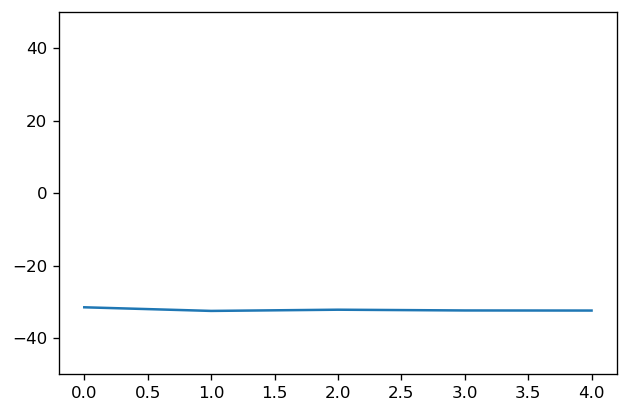

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(num_episodes), avg_rewards, '-')
ax.set_ylim([-50, 50])

In [6]:
agent.save_model('./30000_episodes_negamax')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./30000_episodes_negamax\assets


In [7]:
from D3QNAgent import Agent
def my_agent(obs, config):
    agent = Agent(config)
    agent.load_model('./30000_episodes_negamax')
    return agent.choose_action(obs.board)

In [12]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent, random_agent])
env.render(mode="ipython", width=500, height=450)

In [9]:
# def mean_reward(rewards):
#     return sum(r[0] for r in rewards) / float(len(rewards))
    
# print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))